In [1]:
import pandas as pd
import quandl
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import math
import numpy as np

In [2]:
df = quandl.get("WGC/GOLD_DAILY_USD")

In [3]:
df.shape

(10462, 1)

In [4]:
df['day'] = df.index.to_series()

In [5]:
mask = (df['day'] > '2008-1-1') & (df['day'] <= '2014-12-31')
#print(df.loc[mask])

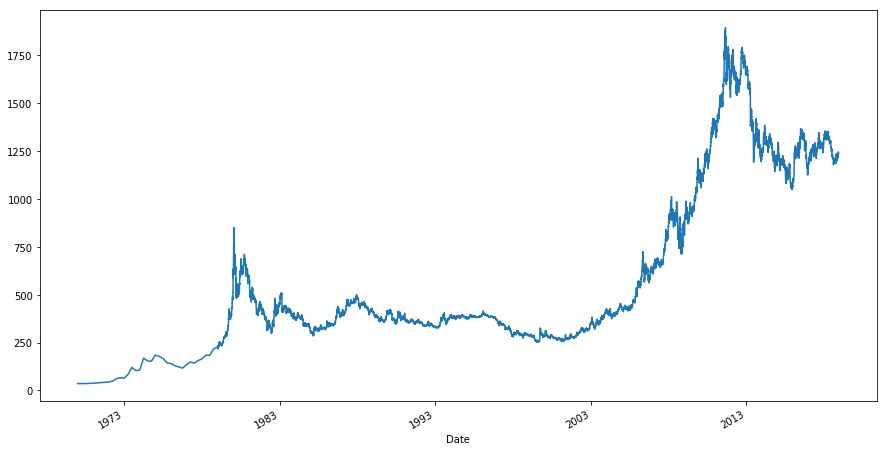

In [6]:
plt.rcParams['figure.figsize'] = [15, 8]
#df.loc[mask].Value.plot.line();
df.Value.plot.line();
#df.loc[mask].Value.rolling(window=50).mean().plot.line()
#df.loc[mask].Value.rolling(window=70).mean().plot.line()

In [7]:
df.head()

,Value,day
Date,,
1970-01-01,35.2,1970-01-01
1970-04-01,35.1,1970-04-01
1970-07-01,35.4,1970-07-01
1970-10-01,36.2,1970-10-01
1971-01-01,37.4,1971-01-01


#### Feature engineering

In [8]:
## Date features
df_features = df.copy()
df_features['dayofmonth'] = df_features.day.dt.day
df_features['dayofweek'] = df_features.day.dt.dayofweek
df_features['month'] = df_features.day.dt.month
df_features['year'] = df_features.day.dt.year
df_features.head()

,Value,day,dayofmonth,dayofweek,month,year
Date,,,,,,
1970-01-01,35.2,1970-01-01,1,3,1,1970
1970-04-01,35.1,1970-04-01,1,2,4,1970
1970-07-01,35.4,1970-07-01,1,2,7,1970
1970-10-01,36.2,1970-10-01,1,3,10,1970
1971-01-01,37.4,1971-01-01,1,4,1,1971


In [9]:
#### Value features
#for i in range(1,4):
#    df_features['value_d-'+str(i)] = df_features['Value'].shift(i)

df_features['small_MA'] = df.Value.rolling(window=20).mean()
df_features['big_MA'] = df.Value.rolling(window=30).mean()

# retira os primeiros registros após o shift, pois esses possuem NaN em suas colunas
df_features.dropna(inplace=True)

In [10]:
df_features.head()

,Value,day,dayofmonth,dayofweek,month,year,small_MA,big_MA
Date,,,,,,,,
1977-04-01,148.3,1977-04-01,1,4,4,1977,127.120,97.816667
1977-07-01,142.6,1977-07-01,1,4,7,1977,131.145,101.396667
1977-10-03,155.5,1977-10-03,3,0,10,1977,135.645,105.410000
1978-01-02,165.0,1978-01-02,2,0,1,1978,140.700,109.730000
1978-04-03,183.4,1978-04-03,3,0,4,1978,145.650,114.636667


In [11]:
# split into train and test sets
train_size = int(len(df_features) * 0.9)
test_size = len(df_features) - train_size
train = df_features[:train_size]
test = df_features[train_size:]

In [12]:
len(train), len(test), len(train) + len(test)

(9389, 1044, 10433)

#### random forest

In [13]:
reg = RandomForestRegressor(max_depth=5, random_state=42,n_estimators=100)

In [14]:
feats = df_features.columns
feats = feats[2:]
feats

Index(['dayofmonth', 'dayofweek', 'month', 'year', 'small_MA', 'big_MA'], dtype='object')

In [15]:
reg.fit(train[feats], train['Value'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [16]:
trainPredict = reg.predict(train[feats])
testPredict = reg.predict(test[feats])

In [17]:
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(test['Value'], testPredict))

# RMSE
print("Root Mean squared error: %.2f"
      % math.sqrt(mean_squared_error(test['Value'], testPredict)))

# Explained variance score: 1 is perfect prediction
print('R2 score: %.2f' % r2_score(test['Value'], testPredict))

Mean squared error: 1138.68
Root Mean squared error: 33.74
R2 score: 0.78


In [18]:
for i in range(9):
    trainPredict = np.insert(trainPredict, 0, [np.NaN])
for i in range(len(trainPredict)):
    testPredict = np.insert(testPredict, 0, [np.NaN])

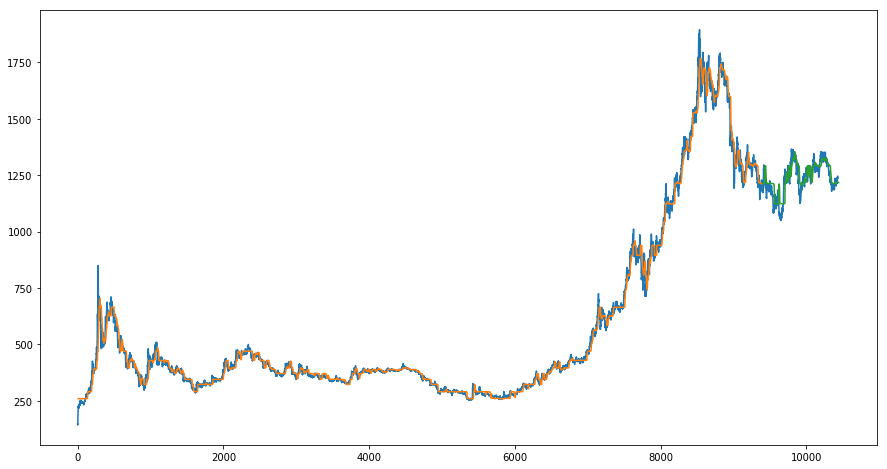

In [19]:
 # plot baseline and predictions
plt.plot(df_features['Value'].values)
plt.plot(trainPredict)
plt.plot(testPredict)
plt.rcParams['figure.figsize'] = [15, 8]
plt.show()

In [20]:
estimator = reg.estimators_[9]

In [21]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, 
                out_file='tree.dot', 
                feature_names = feats,
                class_names = df_features['Value'],
                rounded = True, proportion = False, 
                precision = 2, filled = True)

In [22]:
# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

0

In [23]:
# Display in jupyter notebook
#from IPython.display import Image
#Image(filename = 'data/tree.png')

Feature ranking:
1. feature small_MA (0.922089)
2. feature big_MA (0.077688)
3. feature month (0.000134)
4. feature year (0.000088)
5. feature dayofmonth (0.000001)
6. feature dayofweek (0.000000)


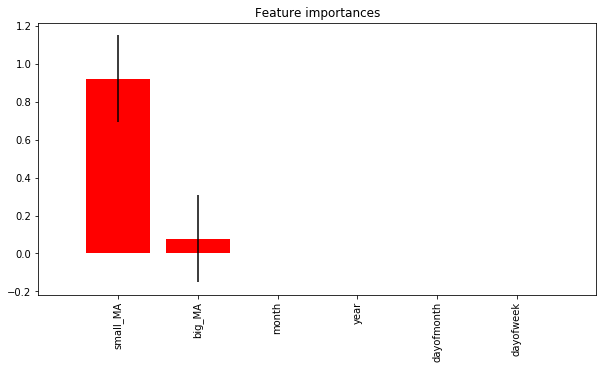

In [24]:
plt.rcParams['figure.figsize'] = [10, 5]
importances = reg.feature_importances_
std = np.std([tree.feature_importances_ for tree in reg.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train[feats].shape[1]):
    print("%d. feature %s (%f)" % (f + 1, train[feats].columns[indices[f]], importances[indices[f]]))

    
path_to_images = 'img/'
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(train[feats].shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(train[feats].shape[1]), train[feats].columns[indices],rotation=90)
plt.xlim([-1, train[feats].shape[1]])
plt.savefig(path_to_images + 'importancia_features_regressor.png', bbox_inches='tight')
plt.show()